In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import sys
import os
import platform
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('poster')

In [4]:
user_vimms = "vimms"
sys.path.append(user_vimms)

In [5]:
mzmine_path = os.path.join("MZmine-2.53-Windows", "startMZmine-Windows.bat")
old_mzmine = False
template_suffix = "_old" if old_mzmine else ""
mzmine_template = os.path.join(user_vimms, "batch_files", f"multi_sample_peak_pick{template_suffix}.xml")

In [6]:
from vimms.Common import (
    POSITIVE, load_obj,
    set_log_level_warning,
)
from vimms.Experiment import Experiment
from vimms.BoxVisualise import (
    mpl_results_plot, plotly_results_plot,
    plotly_timing_hist, seaborn_timing_hist,
    mpl_fragmentation_events, plotly_fragmentation_events,
    mpl_fragmented_boxes,
    seaborn_uncovered_area_hist,
    BoxViewer
)

/datastore/home1/2185647m/topNEXt_experiments/topNEXt_experiments/vimms/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
ionisation_mode = POSITIVE
pbar = False
set_log_level_warning()

1

In [8]:
#multi_dir = "/Users/%s/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20220706_DDAvsDIA" % user
multi_dir = "20220719_multi_samples_main"
multibeer_dir = os.path.join(multi_dir, "results_4")

In [9]:
num_workers = 20 #can't always use number of physical cores because of memory constraints

Utilities



In [10]:
def load_pkls(pickle_dir, case_names, repeat, load_rois=False):
    exp_pkls = {}
    for case_name in case_names:
        roi_str = "_rois" if load_rois else ""
        exp_pickle_paths = [f"{os.path.join(pickle_dir, case_name)}_{i}{roi_str}.pkl" for i in range(repeat)]
        exp_pkls[case_name] = [load_obj(pkl) for pkl in exp_pickle_paths]
    return exp_pkls

Specify line styles for mpl plots

In [11]:
mpl_colours = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
colour_map = {}

def update_cmap(name):
    if(not name in colour_map):
        colour_map[name] = next(mpl_colours)
    return colour_map[name]

def get_style(name):
    if(name.lower().endswith("smartroi")):
        c = update_cmap("_".join(name.split("_")[:-1]))
        return c, "s"
    elif(name.lower().endswith("weighteddew")):
        c = update_cmap("_".join(name.split("_")[:-1]))
        return c, "^"
    else:
        c = update_cmap(name)
        return c, "o"
    
def get_line_styles(experiment_names):
    colours, markers = [], []
    for exp_name in experiment_names:
        c, m = get_style(exp_name)
        colours.append(c)
        markers.append(m)
    return colours, markers

In [12]:
def get_rep_dirs(out_dir):
    dirs = os.listdir(out_dir)
    rep_dirs = []
    
    for i in itertools.count(0, 1):
        if(not str(i) in dirs): 
            break
        rep_dirs.append(os.path.join(out_dir, str(i)))
        
    return rep_dirs

# 1. Same Beer

In [13]:
repeat = 10
out_dir = "replicate_same_beer"

same_case_names = [
    "topN",
    "topN_RoI",
    "topN_exclusion",
    "topNEx",
    "topNEx_smartroi",
    "topNEx_weighteddew",
    "hard_roi_exclusion",
    "hard_roi_exclusion_smartroi",
    "hard_roi_exclusion_weighteddew",
    "intensity_roi_exclusion",
    "intensity_roi_exclusion_smartroi",
    "intensity_roi_exclusion_weighteddew",
    "non_overlap",
    "non_overlap_smartroi",
    "non_overlap_weighteddew",
    "intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    "intensity_non_overlap_weighteddew",
]

line_colours, line_markers = get_line_styles(same_case_names)

In [14]:
isolation_width = 1.0
reports_list = []

for rep_dir in get_rep_dirs(out_dir):
    same_beer_exp = Experiment.load_from_json(
        file_dir = rep_dir,
        file_name = "keyfile.json",
        out_dir = rep_dir,
        fullscan_dir = multibeer_dir,
        amend_result_path = True,
        case_names = same_case_names
    )
    
    true_repeat = min(
        repeat,
        len(same_beer_exp.case_mzmls[same_beer_exp.case_names[0]])
    )
    
    same_beer_exp.evaluate(
        num_workers = num_workers,
        isolation_widths = isolation_width,
        max_repeat = true_repeat,
        aligned_names = f"multibeers_1_{true_repeat}" + template_suffix,
        mzmine_templates = mzmine_template,
        mzmine_exe = mzmine_path,
        force_peak_picking = False,
        check_mzmine="exact"
    )
    
    reports_list.append(
        same_beer_exp.get_reports(num_workers=num_workers)
    )

2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file
2024 aligned boxes contained in file

3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file
3085 aligned boxes contained in file


In [15]:
coverages = []
it_coverages = []

for case_name in same_case_names:
    coverages.append([
        r[case_name]["cumulative_coverage_proportion"][-1] 
        for r in reports_list
    ])
    
    it_coverages.append([
        r[case_name]["cumulative_intensity_proportion"][-1] 
        for r in reports_list
    ])
    
print(coverages)
print()
print(it_coverages)

[[0.7633399209486166, 0.7393841166936791, 0.7676125244618396, 0.7493403693931399, 0.7422859626249457, 0.7598014888337469, 0.738255033557047, 0.7452471482889734, 0.7573135558302431, 0.7510056315366049], [0.7628458498023716, 0.7384116693679093, 0.7685909980430529, 0.7444402563136072, 0.7435897435897436, 0.7627791563275435, 0.7378355704697986, 0.746092099704267, 0.757725587144623, 0.7534191472244569], [0.9901185770750988, 0.9912479740680713, 0.9907045009784736, 0.9871843196381455, 0.9834854411125598, 0.9895781637717121, 0.9899328859060402, 0.9898605830164765, 0.9888751545117429, 0.9903459372485921], [0.9886363636363636, 0.9909238249594814, 0.9897260273972602, 0.9868073878627969, 0.984354628422425, 0.9885856079404467, 0.9911912751677853, 0.9890156316011829, 0.9876390605686032, 0.9911504424778761], [0.9836956521739131, 0.9844408427876823, 0.9828767123287672, 0.9822842065586129, 0.9808778791829639, 0.9821339950372209, 0.9861577181208053, 0.9805661174482467, 0.9859909353110836, 0.983507642799

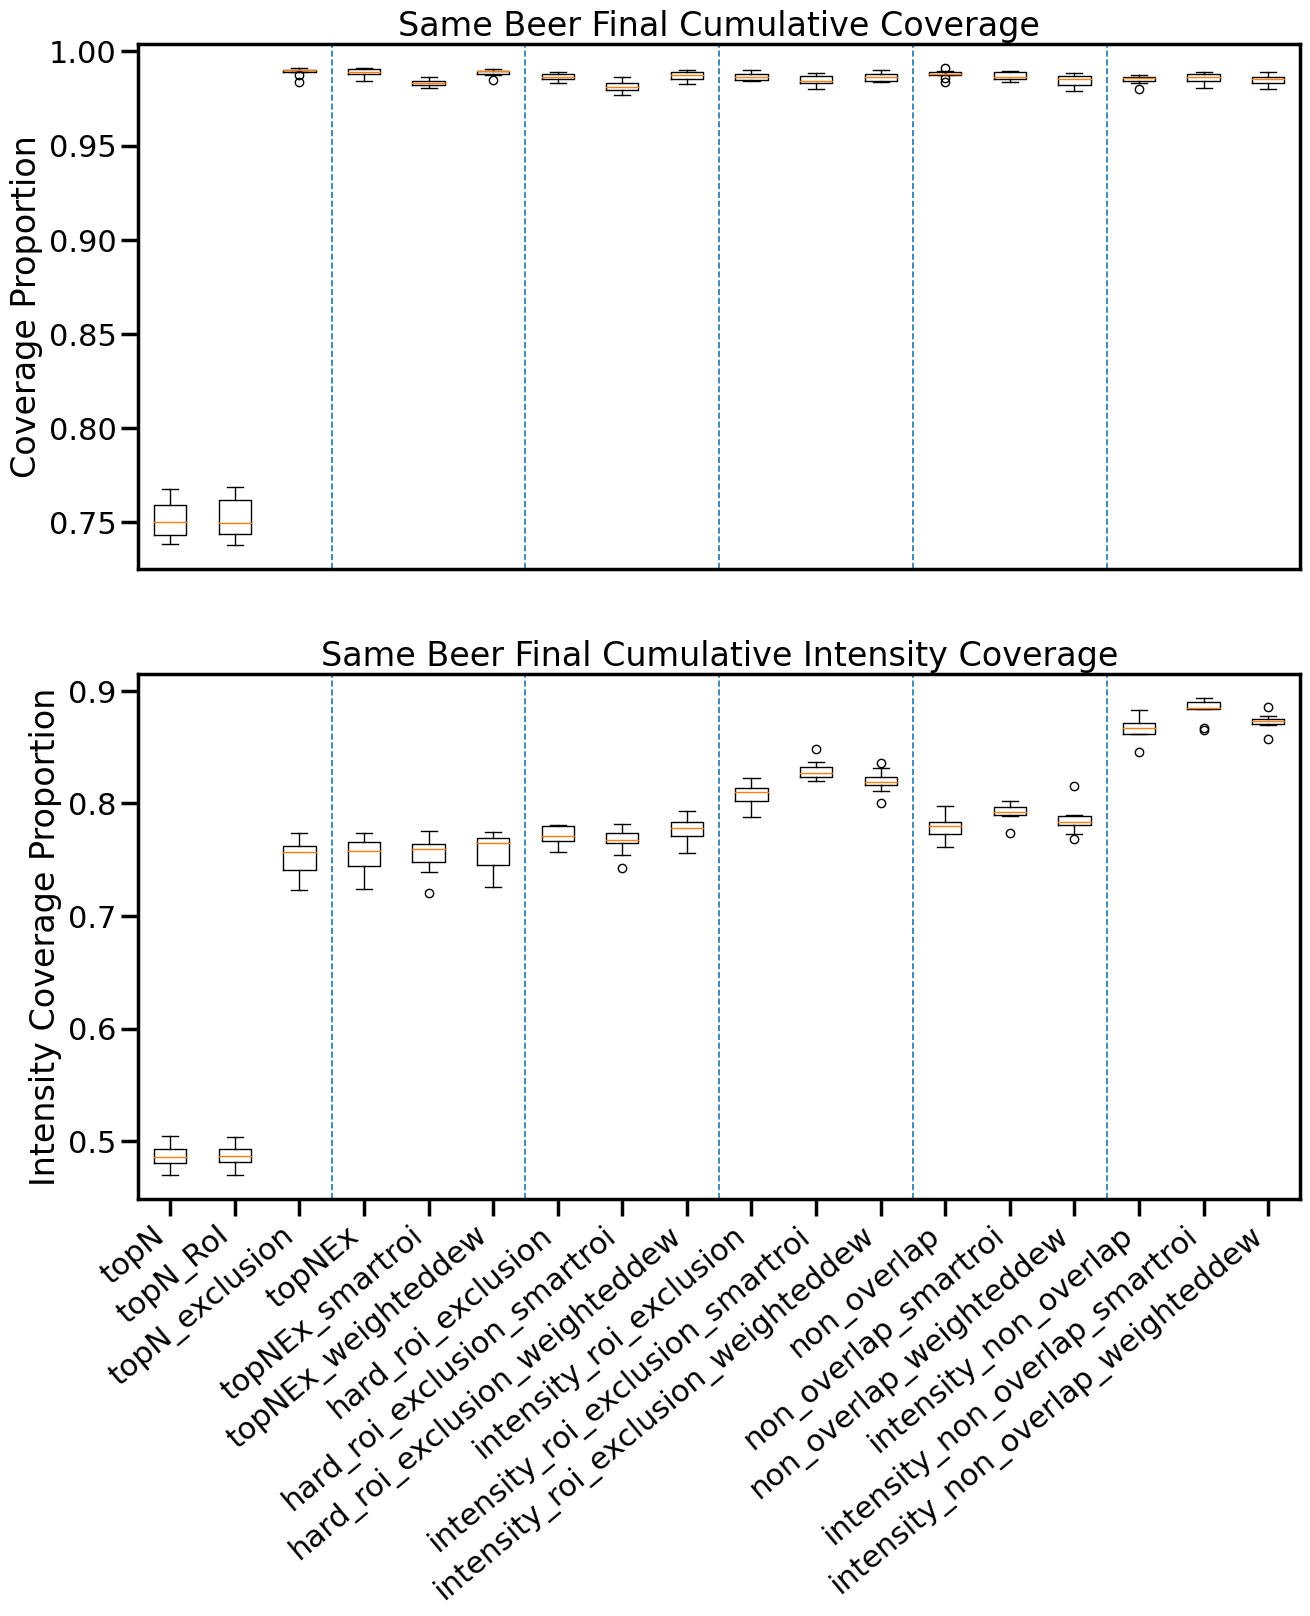

In [16]:
fig, axes = plt.subplots(2, 1)
ax1, ax2 = axes

for i in range(3, len(same_case_names), 3):
    ax1.axvline(i + 0.5, linestyle="--", linewidth=1.2)
    ax2.axvline(i + 0.5, linestyle="--", linewidth=1.2)

ax1.boxplot(coverages)
ax1.tick_params(
    bottom=False,
    labelbottom=False
)
ax1.set(title="Same Beer Final Cumulative Coverage", ylabel="Coverage Proportion")

ax2.boxplot(it_coverages)
ax2.set_xticklabels(same_case_names, rotation=40, ha="right")
ax2.set(title="Same Beer Final Cumulative Intensity Coverage", ylabel="Intensity Coverage Proportion")

fig.set_size_inches(15, 15)

# 2. Repeating Different Beers

In [17]:
bio_repeat = 6
tech_repeat = 4
repeat = bio_repeat * tech_repeat
out_dir = "replicate_repeated_different_beer"

rep_diff_case_names = [
    "topN",
    "topN_RoI",
    "topN_exclusion",
    "topNEx",
    "topNEx_smartroi",
    "topNEx_weighteddew",
    "hard_roi_exclusion",
    "hard_roi_exclusion_smartroi",
    "hard_roi_exclusion_weighteddew",
    "intensity_roi_exclusion",
    "intensity_roi_exclusion_smartroi",
    "intensity_roi_exclusion_weighteddew",
    "non_overlap",
    "non_overlap_smartroi",
    "non_overlap_weighteddew",
    "intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    "intensity_non_overlap_weighteddew",
]

line_colours, line_markers = get_line_styles(rep_diff_case_names)

In [18]:
isolation_width = 1.0
reports_list = []

for rep_dir in get_rep_dirs(out_dir):
    rep_diff_beer_exp = Experiment.load_from_json(
        file_dir = rep_dir,
        file_name = "keyfile.json",
        out_dir = rep_dir,
        fullscan_dir = multibeer_dir,
        amend_result_path = True,
        case_names = rep_diff_case_names
    )
    
    true_repeat = min(
        repeat,
        len(rep_diff_beer_exp.case_mzmls[rep_diff_beer_exp.case_names[0]])
    )
    
    rep_diff_beer_exp.evaluate(
        num_workers = num_workers,
        isolation_widths = isolation_width,
        max_repeat = true_repeat,
        aligned_names = f"multibeers_{bio_repeat}_{tech_repeat}" + template_suffix,
        mzmine_templates = mzmine_template,
        mzmine_exe = mzmine_path,
        force_peak_picking = False,
        check_mzmine="exact"
    )
    
    reports_list.append(
        rep_diff_beer_exp.get_reports(num_workers=num_workers)
    )

6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file
6291 aligned boxes contained in file

5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file
5209 aligned boxes contained in file


In [19]:
coverages = []
it_coverages = []

for case_name in rep_diff_case_names:
    coverages.append([
        r[case_name]["cumulative_coverage_proportion"][-1] 
        for r in reports_list
    ])
    
    it_coverages.append([
        r[case_name]["cumulative_intensity_proportion"][-1] 
        for r in reports_list
    ])
    
print(coverages)
print()
print(it_coverages)

[[0.7588618661580036, 0.7761566519485505, 0.7645923781958515, 0.7586726998491704, 0.7575998726722903, 0.7768733041118764, 0.7633067198935463, 0.7547645298472201, 0.7596401028277635, 0.7622312246805859], [0.7588618661580036, 0.7757727010942599, 0.7633059977488342, 0.758505111446288, 0.7580773515836384, 0.7764558547276142, 0.7631403858948769, 0.7544495196093873, 0.7604434447300771, 0.7616079775631037], [0.891591161977428, 0.8667690535611442, 0.8776330599774883, 0.8987766046589576, 0.8908164889384053, 0.8768524316426634, 0.8882235528942116, 0.8780910379587337, 0.8901028277634961, 0.8889062013088189], [0.8909553330154188, 0.8646573238625456, 0.874095513748191, 0.8939165409753645, 0.8842909438166481, 0.8695470674180755, 0.8815701929474384, 0.8755709560560718, 0.8836760925449871, 0.8825179183546276], [0.9241773962804005, 0.9220579765789979, 0.9232995658465991, 0.930785989609519, 0.9237625338214229, 0.918388645376748, 0.9153359946773121, 0.9251850685147267, 0.9227185089974294, 0.9269242754752

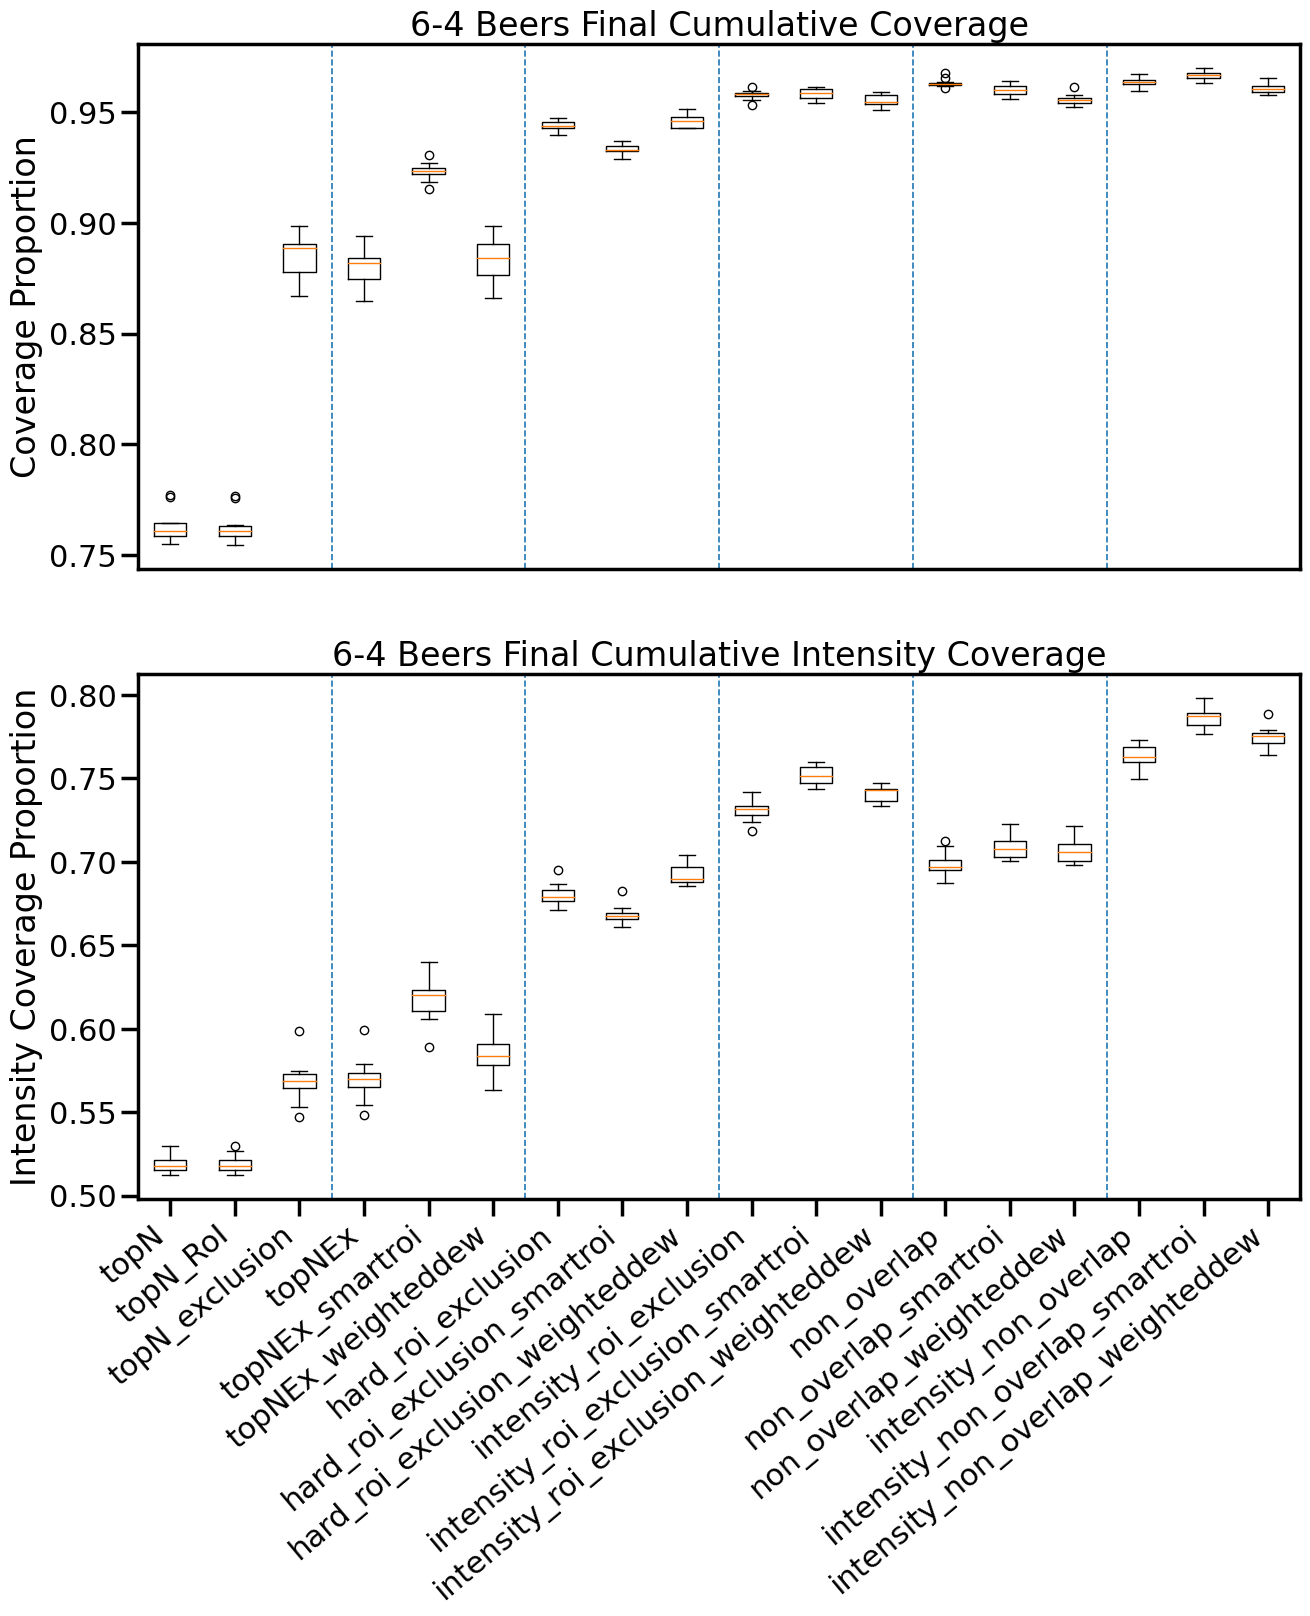

In [20]:
fig, axes = plt.subplots(2, 1)
ax1, ax2 = axes

for i in range(3, len(rep_diff_case_names), 3):
    ax1.axvline(i + 0.5, linestyle="--", linewidth=1.2)
    ax2.axvline(i + 0.5, linestyle="--", linewidth=1.2)

ax1.boxplot(coverages)
ax1.tick_params(
    bottom=False,
    labelbottom=False
)
ax1.set(title="6-4 Beers Final Cumulative Coverage", ylabel="Coverage Proportion")

ax2.boxplot(it_coverages)
ax2.set_xticklabels(rep_diff_case_names, rotation=40, ha="right")
ax2.set(title="6-4 Beers Final Cumulative Intensity Coverage", ylabel="Intensity Coverage Proportion")

fig.set_size_inches(15, 15)